[View in Colaboratory](https://colab.research.google.com/github/rossy114/FX-Git/blob/master/2sigma.ipynb)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!ls "/content/drive/My Drive/Colab Notebooks"

'Copy of salt_identification.ipynb'   train.h5	     Untitled0.ipynb
'Copy of Untitled0.ipynb'	      train.h5.zip


In [16]:
!pip install --upgrade pandas
!pip install --upgrade tables

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.23.4)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.4.4)


In [0]:
import pandas as pd

with pd.HDFStore ("/content/drive/My Drive/Colab Notebooks/train.h5", "r") as train:
  df=train.get("train")

In [19]:
len(df)

1710756

In [20]:
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,...,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,-0.179404,NaN,-0.072108,0.249187,0.024401,-0.127942,NaN,1.412742,-0.029575,1.265246,-0.055747,1.592256,-0.285275,-0.212888,0.404180,0.116903,0.197590,-0.197455,-0.195023,-0.059886,-0.021199,-0.013555,-0.236371,-0.253357,0.575562,0.283947,-0.006208,0.616351,-0.034578,0.732652,...,NaN,-2.0,NaN,NaN,-2.0,-0.273957,NaN,-2.0,-2.0,NaN,0.001652,-2.0,NaN,-2.0,NaN,0.652981,0.000000,-0.142453,0.0,NaN,NaN,1.427469,NaN,-2.0,0.0,NaN,NaN,NaN,0.0,0.937880,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,0.216281,0.09675,0.082042,-0.224383,-0.085529,0.024763,-0.062337,-0.202247,1.746692,-0.187505,-0.034664,-0.135177,0.305562,0.027595,-0.208746,0.118520,-0.123511,0.113818,NaN,-0.115837,0.028282,0.076565,-0.217346,0.100054,0.358808,0.057505,0.025719,-0.141339,2.293476,0.024945,...,NaN,-2.0,NaN,NaN,-2.0,-0.159432,NaN,0.0,-2.0,NaN,0.004317,0.0,NaN,-2.0,NaN,-0.399520,0.000000,-0.309356,-0.5,NaN,NaN,0.154613,NaN,0.0,0.0,NaN,NaN,NaN,0.5,0.232154,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,NaN,NaN,-0.051418,-0.258330,-0.122140,-0.121041,-0.058287,-0.899515,-0.022131,-0.079002,-0.031116,-0.100603,-0.341474,-0.007522,0.077977,-0.149581,0.036946,0.166182,NaN,0.172751,0.961091,1.028205,-0.165369,0.056006,NaN,0.249530,-0.156078,NaN,0.019192,0.053364,...,NaN,-2.0,NaN,NaN,-2.0,-0.227811,NaN,-2.0,-2.0,NaN,0.000000,-2.0,NaN,-2.0,NaN,-0.496284,0.006942,0.122841,-0.5,NaN,NaN,0.378332,NaN,-2.0,0.0,NaN,NaN,NaN,-0.5,0.372688,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,-0.097903,NaN,NaN,-0.093677,-0.026951,NaN,-0.049881,0.019866,0.009357,0.229889,0.018161,0.050572,0.168919,-0.444931,-0.310245,0.500396,-0.033734,0.050415,0.382963,-0.098141,NaN,-0.216800,NaN,NaN,0.093820,0.201814,-0.281830,0.102403,0.000135,-0.114420,...,NaN,0.0,NaN,NaN,-2.0,-0.106334,NaN,NaN,-2.0,NaN,0.000000,-2.0,NaN,0.0,NaN,0.990627,0.006766,0.812678,0.0,NaN,NaN,1.023713,NaN,-2.0,0.0,NaN,NaN,NaN,-0.5,0.751021,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,0.196391,NaN,-0.163880,-0.019844,-0.035681,0.112920,0.104239,-0.167811,-0.025993,-0.228427,0.139590,-0.075597,-0.141695,-0.033661,0.021833,3.211807,0.328052,-0.129948,-0.132339,0.037320,0.064364,-0.140153,-0.146839,-0.116609,-0.215639,2.448706,-0.227971,-0.226776,-0.048719,3.832646,...,NaN,-2.0,NaN,NaN,0.0,0.000000,NaN,0.0,-2.0,NaN,0.000000,-2.0,NaN,-2.0,NaN,-0.086685,0.006236,-0.411145,-0.5,NaN,NaN,0.741545,NaN,0.0,0.0,NaN,NaN,NaN,0.5,0.595206,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


In [21]:
labels =[]
values=[]

for col in df.columns:
  labels.append(col)
  values.append(df[col].isnull().sum())
  print(col, values[-1])

id 0
timestamp 0
derived_0 72959
derived_1 81029
derived_2 398651
derived_3 149471
derived_4 406458
fundamental_0 23947
fundamental_1 679070
fundamental_2 368840
fundamental_3 454380
fundamental_5 962020
fundamental_6 701625
fundamental_7 26340
fundamental_8 373166
fundamental_9 565567
fundamental_10 112977
fundamental_11 368840
fundamental_12 110871
fundamental_13 355138
fundamental_14 356084
fundamental_15 354897
fundamental_16 355138
fundamental_17 97222
fundamental_18 15833
fundamental_19 54588
fundamental_20 110871
fundamental_21 54333
fundamental_22 558488
fundamental_23 356723
fundamental_24 576655
fundamental_25 121894
fundamental_26 657184
fundamental_27 281298
fundamental_28 667331
fundamental_29 354106
fundamental_30 354907
fundamental_31 454380
fundamental_32 111672
fundamental_33 13835
fundamental_34 434862
fundamental_35 424476
fundamental_36 15843
fundamental_37 355843
fundamental_38 803489
fundamental_39 377574
fundamental_40 279702
fundamental_41 30115
fundamental_42 2

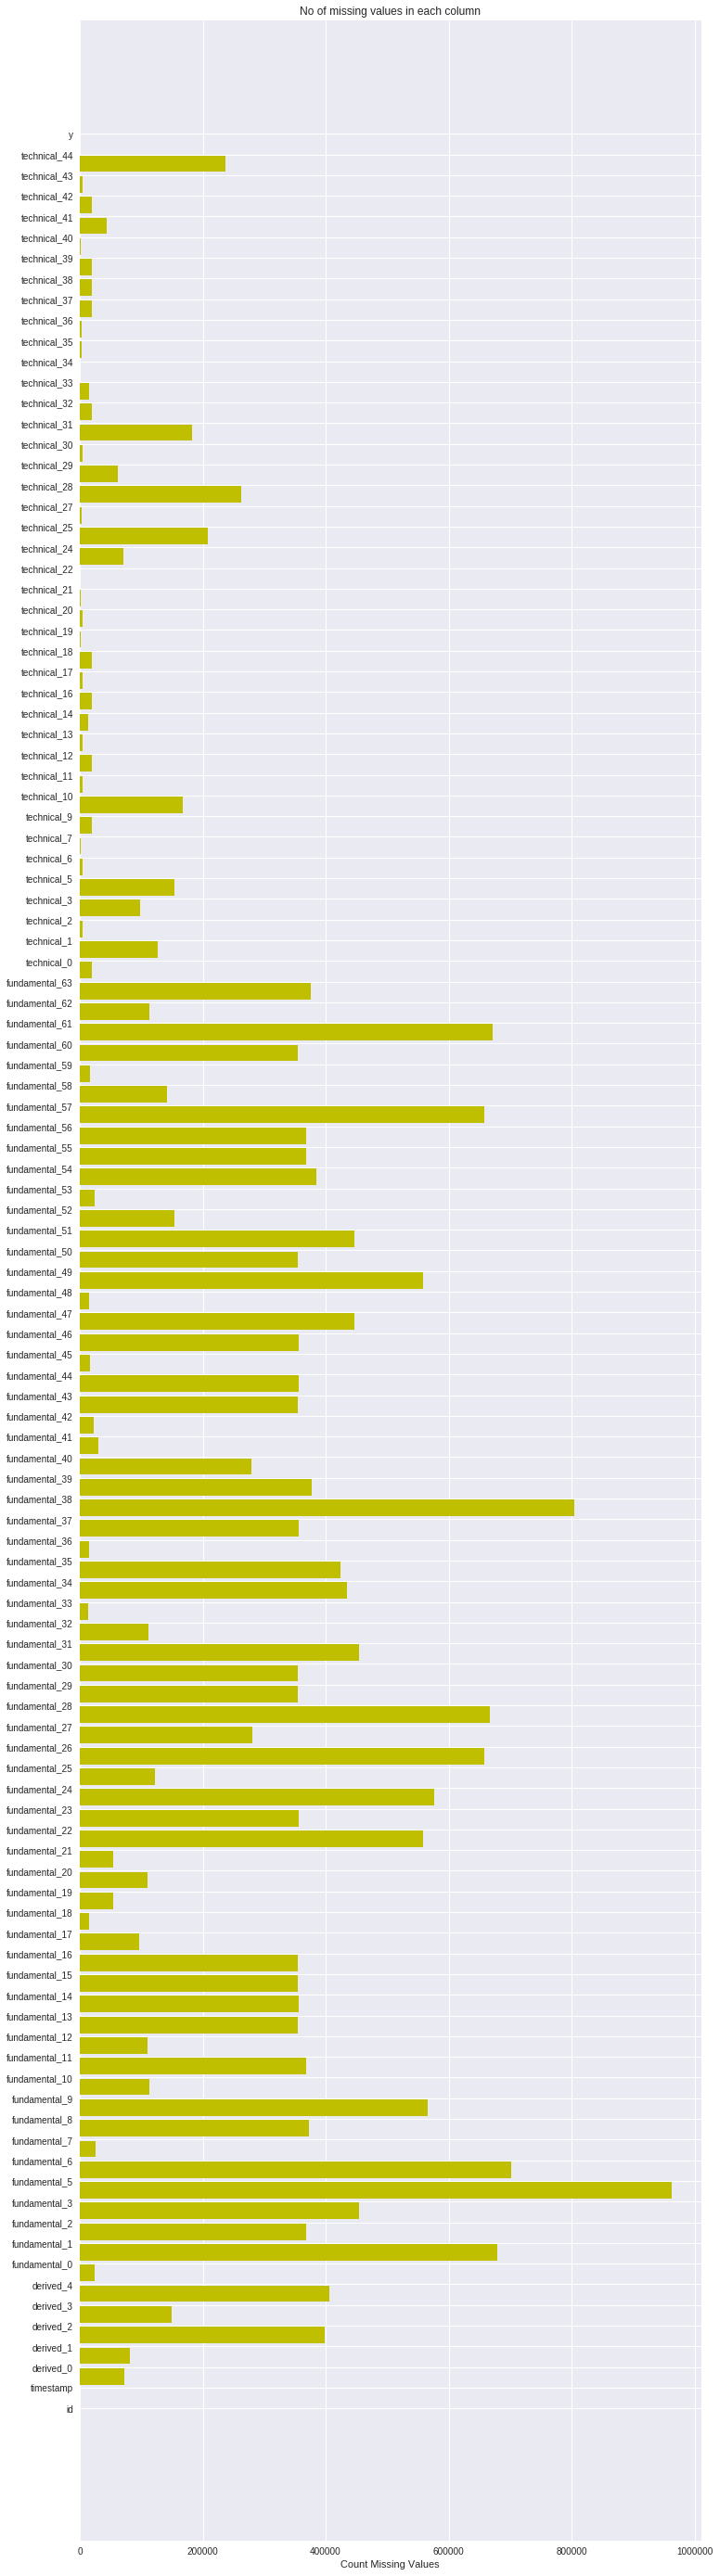

In [22]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
  
ind= np.arange(len(labels))
width=0.9
fig, ax=plt.subplots(figsize=(12,50))
rects=ax.barh(ind,np.array(values),color='y')
ax.set_yticks(ind+(width/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel('Count Missing Values')
ax.set_title('No of missing values in each column')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


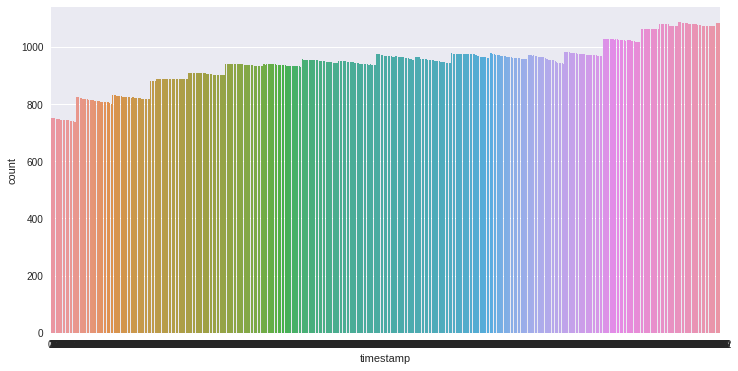

In [23]:
import seaborn as sns

fig=plt.figure(figsize=(12,6))
sns.countplot(x='timestamp',data=df)
plt.show()

In [24]:
print(len(df.id.unique()))

1424


In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# This is taken from Frans Slothoubers post on the contest discussion forum.
# https://www.kaggle.com/slothouber/two-sigma-financial-modeling/kagglegym-emulation


def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score


def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r


class Observation(object):
    def __init__(self, train, target, features):
        self.train = train
        self.target = target
        self.features = features


class Environment(object):
    def __init__(self):
        with pd.HDFStore("/content/drive/My Drive/Colab Notebooks/train.h5", "r") as hfdata:
            self.timestamp = 0
            fullset = hfdata.get("train")
            self.unique_timestamp = fullset["timestamp"].unique()
            # Get a list of unique timestamps
            # use the first half for training and
            # the second half for the test set
            n = len(self.unique_timestamp)
            i = int(n/2)
            timesplit = self.unique_timestamp[i]
            self.n = n
            self.unique_idx = i
            self.train = fullset[fullset.timestamp < timesplit]
            self.test = fullset[fullset.timestamp >= timesplit]

            # Needed to compute final score
            self.full = self.test.loc[:, ['timestamp', 'y']]
            self.full['y_hat'] = 0.0
            self.temp_test_y = None

    def reset(self):
        timesplit = self.unique_timestamp[self.unique_idx]

        self.unique_idx = int(self.n / 2)
        self.unique_idx += 1
        subset = self.test[self.test.timestamp == timesplit]

        # reset index to conform to how kagglegym works
        target = subset.loc[:, ['id', 'y']].reset_index(drop=True)
        self.temp_test_y = target['y']

        target.loc[:, 'y'] = 0.0  # set the prediction column to zero

        # changed bounds to 0:110 from 1:111 to mimic the behavior
        # of api for feature
        features = subset.iloc[:, :110].reset_index(drop=True)

        observation = Observation(self.train, target, features)
        return observation

    def step(self, target):
        timesplit = self.unique_timestamp[self.unique_idx-1]
        # Since full and target have a different index we need
        # to do a _values trick here to get the assignment working
        y_hat = target.loc[:, ['y']]
        self.full.loc[self.full.timestamp == timesplit, ['y_hat']] = y_hat._values

        if self.unique_idx == self.n:
            done = True
            observation = None
            reward = r_score(self.temp_test_y, target.loc[:, 'y'])
            score = r_score(self.full['y'], self.full['y_hat'])
            info = {'public_score': score}
        else:
            reward = r_score(self.temp_test_y, target.loc[:, 'y'])
            done = False
            info = {}
            timesplit = self.unique_timestamp[self.unique_idx]
            self.unique_idx += 1
            subset = self.test[self.test.timestamp == timesplit]

            # reset index to conform to how kagglegym works
            target = subset.loc[:, ['id', 'y']].reset_index(drop=True)
            self.temp_test_y = target['y']

            # set the prediction column to zero
            target.loc[:, 'y'] = 0

            # column bound change on the subset
            # reset index to conform to how kagglegym works
            features = subset.iloc[:, 0:110].reset_index(drop=True)

            observation = Observation(self.train, target, features)

        return observation, reward, done, info

    def __str__(self):
        return "Environment()"


def make():
    return Environment()


In [61]:

env = make()
observation = env.reset()

print(len(observation.target))
print(len(observation.train))

n = 0
rewards = []
while True:
  target = observation.target
  target.loc[:, 'y'] = 0.01
  observation, reward, done, info = env.step(target)
  if done:
    break
    rewards.append(reward)
    n = n + 1

print(info)
print(n)
print(rewards[0:15])
    

968
806298
{'public_score': -0.42791845523709543}
0
[]


In [60]:
test()

968
806298
